Fit solar radio bursts via Bezier curves interactively

In [1]:
import warnings
warnings.filterwarnings('ignore')
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.colors import LogNorm
import astropy.io.fits as fits
from ipywidgets import IntSlider, FloatSlider, Layout, interact
import matplotlib as mpl
mpl.rcParams['date.epoch'] = '1970-01-01T00:00:00'
try: mdates.set_epoch('1970-01-01T00:00:00')
except: pass
import radioTools_ver2 as rt
import detectRadioburst_ver2 as drb

ModuleNotFoundError: No module named 'radioTools_ver2'

In [ ]:
YEAR  = '2023'
MONTH = '09'
DAY   = '24'
START_TIME_HR  = '14'
START_TIME_MIN = '40'
START_TIME_SEC = '00'
END_TIME_HR  = '15'
END_TIME_MIN = '10'
END_TIME_SEC = ''
SASID_LBA = 'L2025229'

# basedir = '/Users/kkozarev/Downloads/lofar_psp'
basedir   = '/Users/mnedal/Downloads'
lofar_dir = f'{basedir}/LOFAR_data/'

In [ ]:
# import fits files
glob_term=lofar_dir+'{}_{}{}{}_LBA'.format(SASID_LBA, YEAR, MONTH, DAY)+'/LOFAR_{}{}{}_*.fits'.format(YEAR, MONTH, DAY)
print(glob_term)
lofar_LBA_fits = glob.glob(glob_term)
try:
    lofar_LBA_fits.remove(lofar_dir+'{}_{}{}{}_LBA'.format(SASID_LBA, YEAR, MONTH, DAY)+'/LOFAR_{}{}{}_LBA_OUTER.fits'.format(YEAR, MONTH, DAY))
except:
    pass
lofar_LBA_fits.sort()
print(lofar_LBA_fits)

# import json files
lofar_LBA_json = glob.glob(lofar_dir+'{}_{}{}{}_LBA'.format(SASID_LBA, YEAR, MONTH, DAY)+'/LOFAR_{}{}{}_*.json'.format(YEAR, MONTH, DAY))
try:
    lofar_LBA_json.remove(lofar_dir+'{}_{}{}{}_LBA'.format(SASID_LBA, YEAR, MONTH, DAY)+'/LOFAR_{}{}{}_LBA_OUTER.json'.format(YEAR, MONTH, DAY))
except:
    pass
lofar_LBA_json.sort()

# read and store json filex in a list
LBA_json = []
for file in lofar_LBA_json:
    f = open(file)
    LBA_json.append(json.load(f))
    f.close()

In [ ]:
# read the FREQ axis from one of the fits files
LBA_freq = fits.open(lofar_LBA_fits[0])[1].data['FREQ'][0]

LBA_list = []
for i in range(len(lofar_LBA_fits)):
    # read the fits file 
    tmp = fits.open(lofar_LBA_fits[i])
    df = pd.DataFrame(tmp[0].data)
    # insert the datetimes as index 
    df.insert(loc=0, column='DateTime', value=tmp[1].data['TIME'][0])
    df.set_index(['DateTime'], inplace=True)
    # store the spectra 
    LBA_list.append(df)

# Concat. the list of spectra based on the time index
df_concat_LBA = pd.concat(LBA_list, axis=0)

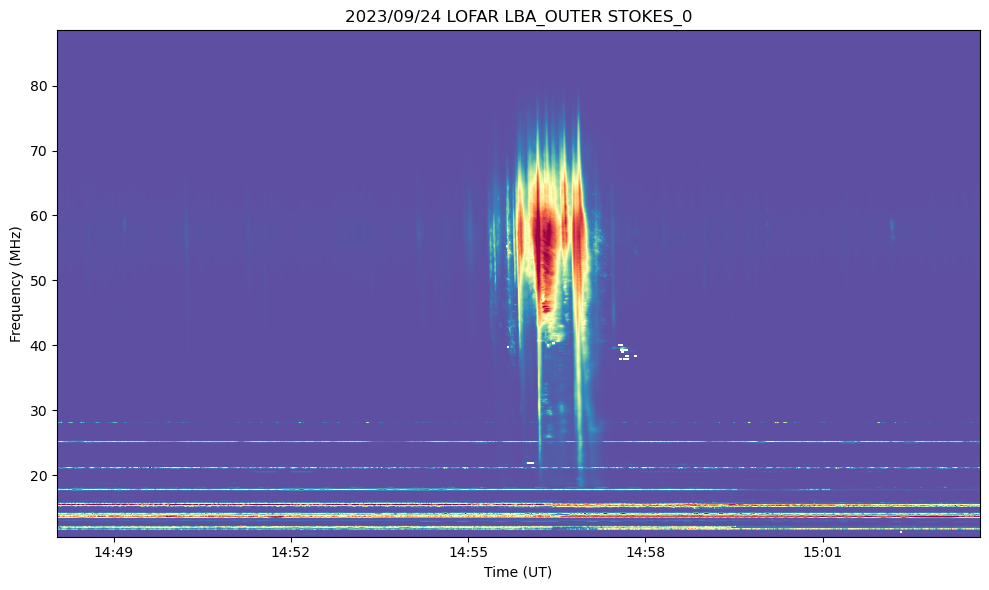

In [27]:
vmin, vmax = np.nanpercentile(df_concat_LBA.values, [25,99.7])

fig, ax = plt.subplots(figsize=[10,6])
ax.imshow(df_concat_LBA.values.T, aspect='auto', origin='lower',
            vmin=vmin, vmax=vmax,
            extent=[df_concat_LBA.index[0], df_concat_LBA.index[-1],
                    LBA_freq[0], LBA_freq[-1]],
            cmap='Spectral_r')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_title(fits.open(lofar_LBA_fits[0])[0].header['CONTENT'])
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

In [143]:
# Remove const background
df = df_concat_LBA.copy()
df_new = df - np.tile(np.nanmedian(df,0), (df.shape[0],1))

array = df_new.values
times = df_new.index
freqs = LBA_freq.copy()

vmin=-3.69e+11, vmax1.40e+15


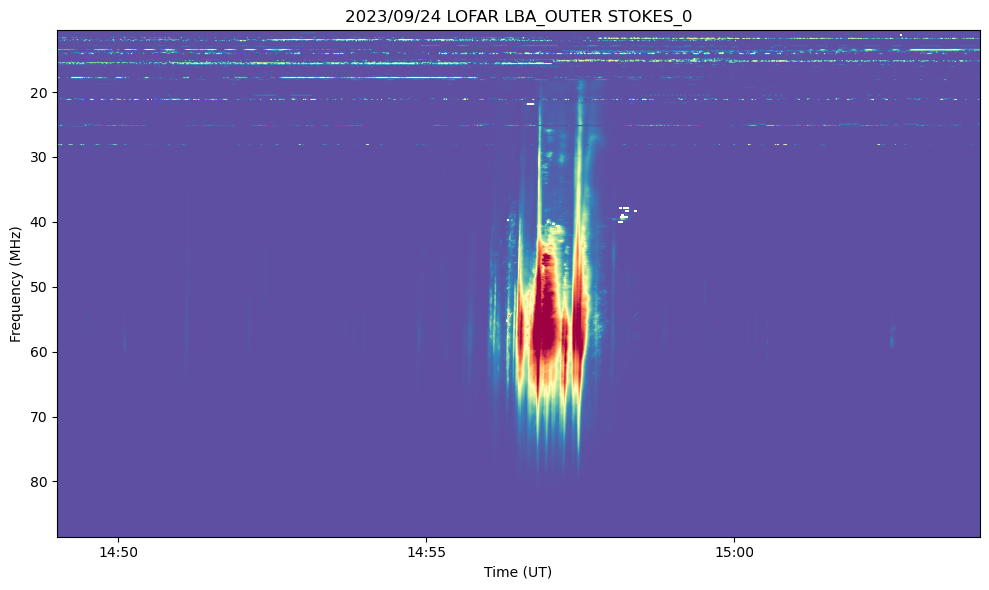

In [144]:
vmin, vmax = np.nanpercentile(array, [25,99.7])
print(f'vmin={vmin:.2e}, vmax{vmax:.2e}')

fig, ax = plt.subplots(figsize=[10,6])
ax.imshow(array.T, aspect='auto', origin='lower',
            vmin=vmin, vmax=vmax,
            extent=[times[0], times[-1],
                    freqs[0], freqs[-1]],
            cmap='Spectral_r')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_title(fits.open(lofar_LBA_fits[0])[0].header['CONTENT'])
ax.invert_yaxis()
ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

In [148]:
n_degree   = 2
# num_points = round(0.7*np.ceil( df.shape[1] * np.diff(df.columns).mean() ))
num_points = 20
array      = df.T.values
psudo_time = np.arange(array.shape[1])
psudo_freq = np.arange(array.shape[0])
layout800  = Layout(width='800px')


def draw_bezier(x1=0, y1=0, x2=0, y2=0, controls=[[0,0]], n=2, num_points=30):
    """
    Draw a Bézier curve of degree n using control points.
    
    Parameters:
    ===========
    - x1, y1: Start point coordinates.
    - x2, y2: End point coordinates.
    - controls: A list of control points, where:
        - 1 control point for n=2 (quadratic).
        - 2 control points for n=3 (cubic).
    - n: Degree of the Bézier curve (2 for quadratic, 3 for cubic).
    - num_points: Number of the curve points.
    
    Returns:
    ========
    - bezier_curve: An array of points [x, y] that form the Bézier curve.
    """
    # Convert points to numpy arrays
    P0 = np.array([x1, y1])  # Start point
    P3 = np.array([x2, y2])  # End point
    
    # Create time steps t from 0 to 1
    t = np.linspace(0, 1, num_points)  # 100 points for smoothness

    if n == 1:  # Linear Bézier (straight line)
        curve = (1 - t)[:, None] * P0 + t[:, None] * P3
    
    elif n == 2:  # Quadratic Bézier curve
        P1 = np.array(controls[0])  # Only 1 control point
        
        # Quadratic Bézier formula
        curve = (1 - t)[:, None] ** 2 * P0 + \
                       2 * (1 - t)[:, None] * t[:, None] * P1 + \
                       t[:, None] ** 2 * P3
    
    elif n == 3:  # Cubic Bézier curve
        if not any(np.isnan(controls[1])):
            P1 = np.array(controls[0])  # First control point
            P2 = np.array(controls[1])  # Second control point
            
            # Cubic Bézier formula
            curve = (1 - t)[:, None] ** 3 * P0 + \
                           3 * (1 - t)[:, None] ** 2 * t[:, None] * P1 + \
                           3 * (1 - t)[:, None] * t[:, None] ** 2 * P2 + \
                           t[:, None] ** 3 * P3
    else:
        P1 = np.array(controls[0])  # Only 1 control point
        
        # Quadratic Bézier formula
        curve = (1 - t)[:, None] ** 2 * P0 + \
                       2 * (1 - t)[:, None] * t[:, None] * P1 + \
                       t[:, None] ** 2 * P3
    
    return curve


def extract_bezier_values(array, x1, y1, x2, y2, controls, n, num_points):
    curve = draw_bezier(x1, y1, x2, y2, controls, n, num_points)
    x_coords = np.round(curve[:, 0]).astype(int)
    y_coords = np.round(curve[:, 1]).astype(int)
    
    # Keep within array bounds
    x_coords = np.clip(x_coords, 0, array.shape[1] - 1)
    y_coords = np.clip(y_coords, 0, array.shape[0] - 1)
    
    values = array[y_coords, x_coords]
    return values, x_coords, y_coords


# Sliders for start/end/control points
x_start = FloatSlider(min=0, max=df.shape[0], step=0.5, value=50, description='x_start', layout=layout800)
y_start = FloatSlider(min=0, max=df.shape[1], step=0.5, value=200, description='y_start', layout=layout800)
x_end   = FloatSlider(min=0, max=df.shape[0], step=0.5, value=150, description='x_end', layout=layout800)
y_end   = FloatSlider(min=0, max=df.shape[1], step=0.5, value=30, description='y_end', layout=layout800)

cx1 = FloatSlider(min=0, max=df.shape[0], step=0.5, value=80, description='cx1', layout=layout800)
cy1 = FloatSlider(min=0, max=df.shape[1], step=0.5, value=100, description='cy1', layout=layout800)
cx2 = FloatSlider(min=0, max=df.shape[0], step=0.5, value=0, description='cx2', layout=layout800)
cy2 = FloatSlider(min=0, max=df.shape[1], step=0.5, value=0, description='cy2', layout=layout800)


def update_plot(x_start, y_start, x_end, y_end, cx1, cy1, cx2, cy2):
    control_points = [[cx1, cy1], [cx2, cy2]]
    curve = draw_bezier(x_start, y_start, x_end, y_end, control_points, n_degree, num_points)

    x_coords = np.round(curve[:, 0]).astype(int)
    y_coords = np.round(curve[:, 1]).astype(int)

    x_coords = np.clip(x_coords, 0, df.shape[1] - 1)
    y_coords = np.clip(y_coords, 0, df.shape[0] - 1)

    
    fig = plt.figure(figsize=[10,6])
    ax  = fig.add_subplot(111)
    
    pc = ax.pcolormesh(psudo_time, psudo_freq, array, vmin=vmin, vmax=vmax, cmap='Spectral_r')

    _, x_coords, y_coords = extract_bezier_values(array, x_start, y_start, x_end, y_end,
                                                  control_points, n_degree, num_points)
    
    ax.plot(x_coords, y_coords, 'wx--', linewidth=1, markersize=3)
    
    ax.scatter(x_start, y_start, c='r', ec='w', s=40, zorder=10, label='Start')
    ax.scatter(x_end, y_end, c='g', ec='w', s=40, zorder=10, label='End')
    ax.scatter(cx1, cy1, c='blue', ec='w', s=40, zorder=10, label='Control 1')
    ax.scatter(cx2, cy2, c='cyan', ec='w', s=40, zorder=10, label='Control 2')
    
    fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=4)
    ax.set_xlabel('Time steps')
    ax.set_ylabel('Frequency steps')
    ax.set_xlim(1400, 2400)
    ax.invert_yaxis()
    fig.tight_layout()
    plt.show()

interact(update_plot, 
         x_start=x_start, y_start=y_start,
         x_end=x_end, y_end=y_end,
         cx1=cx1, cy1=cy1, cx2=cx2, cy2=cy2)

interactive(children=(FloatSlider(value=50.0, description='x_start', layout=Layout(width='800px'), max=3576.0,…

<function __main__.update_plot(x_start, y_start, x_end, y_end, cx1, cy1, cx2, cy2)>

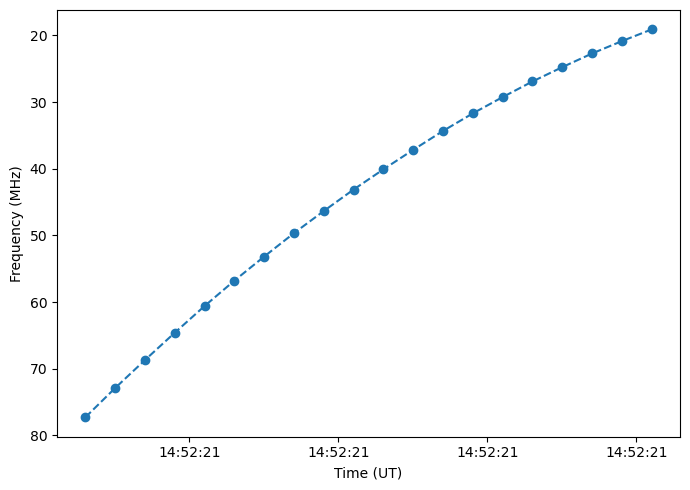

In [154]:
x1 = x_start.get_state()['value']
y1 = y_start.get_state()['value']
x2 = x_end.get_state()['value']
y2 = y_end.get_state()['value']

_, xfit, yfit = extract_bezier_values(array, x1, y1, x2, y2, controls, n_degree, num_points)

fig, ax = plt.subplots(figsize=[7,5])
ax.plot(xfit_dt, freqs[yfit], 'o--')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.invert_yaxis()
ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
fig.tight_layout()
plt.show()